In [1]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from src.models.siamese_triplet.trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

from tqdm.auto import tqdm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt



In [63]:


mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, ncluster, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    inds = np.where(targets==ncluster)[0]
    plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[ncluster])  # np.random.rand(3,)
    for i in range(ncluster):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])  # np.random.rand(3,)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)


def get_labels(dataloader, label_anchors):
    if label_anchors.shape[0] == 1:
        x1 = dataloader.dataset.data[label_anchors].unsqueeze(dim=0)
    else:
        x1 = dataloader.dataset.data[label_anchors]
    dist = torch.cdist(x1=x1, x2=dataloader.dataset.data, p=2)  # (n, n)
    sorted_dist, indices = torch.sort(dist, dim=1, descending=False)
    
    num_anchors = label_anchors.shape[0]
    n = dataloader.dataset.data.shape[0]
    labels = - torch.ones(n)
    for i in range(num_anchors):
        labels[indices[i, :100]] = i
    labels[labels==-1.] = num_anchors
    return labels
    


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        size = dataloader.dataset.data.shape[0]
        batch_size = 256
        embedded_x_list = list()
        for i in tqdm(range(size // batch_size + 1)):
            batch_x = dataloader.dataset.data[batch_size * i: batch_size * (i + 1)].float().to('cuda:0')
            embedded_x = model.get_embedding(batch_x).to('cpu')
            embedded_x_list.append(embedded_x)
    return torch.cat(embedded_x_list, dim=0)


In [3]:
best_model = torch.load('siamese.buffer.pt')

In [10]:
# Set up data loaders
from src.models.siamese_triplet.datasets import SiameseSynthesis
from pathlib import Path

siamese_train_dataset = SiameseSynthesis(Path('../data/train.pt')) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseSynthesis(Path('../data/dev.pt'))

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=2048, shuffle=True)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=2048, shuffle=False)


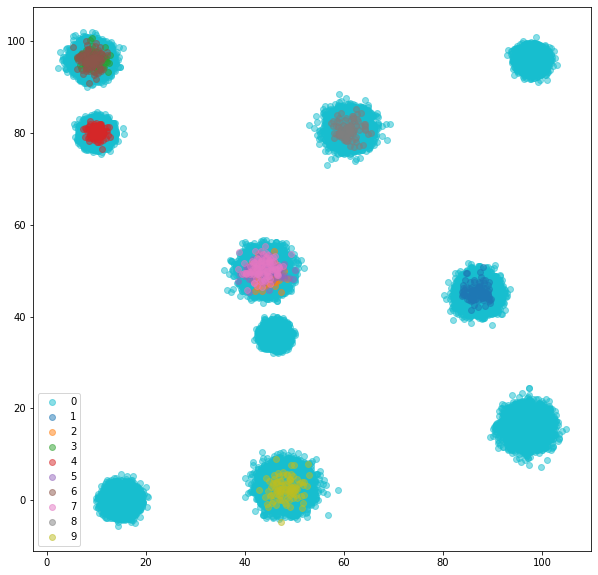

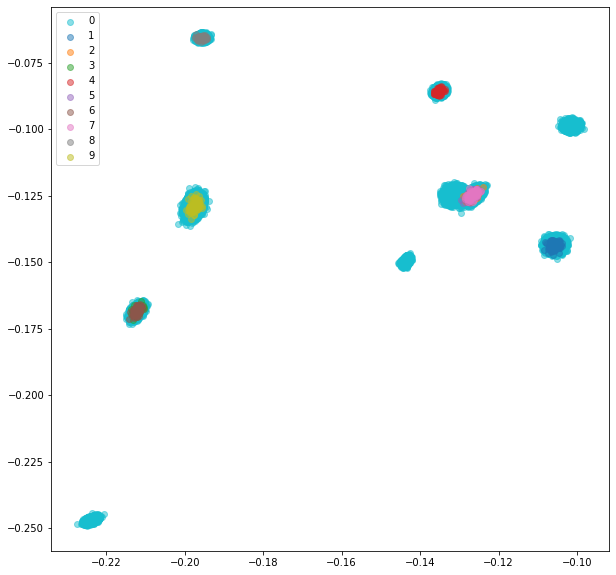

In [11]:

embedded_x = extract_embeddings(siamese_train_loader, best_model)
labels = get_labels(siamese_train_loader, 10 * torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]))
plot_embeddings(siamese_train_loader.dataset.data, labels, ncluster=9)
plot_embeddings(embedded_x, labels, ncluster=9)

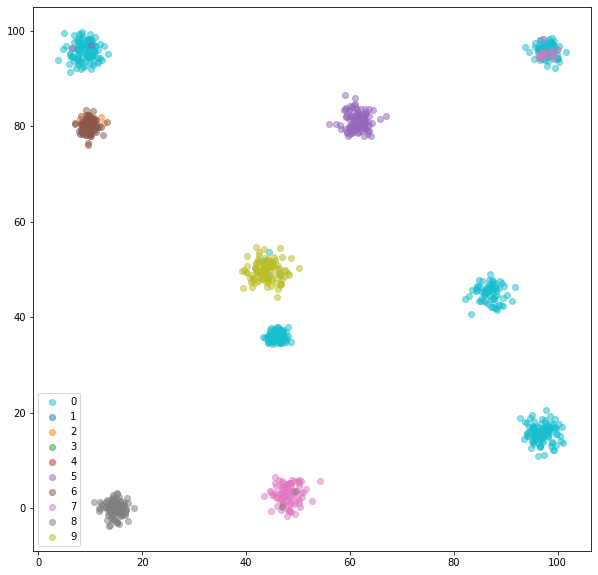

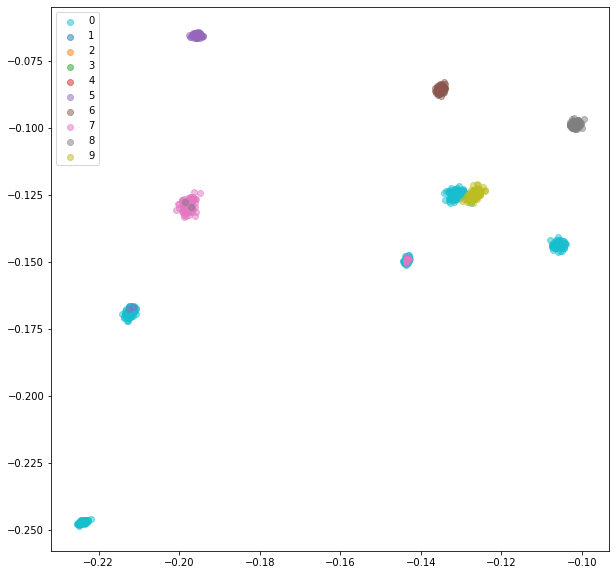

In [12]:
embedded_x = extract_embeddings(siamese_test_loader, best_model)
labels = get_labels(siamese_test_loader, torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]))
plot_embeddings(siamese_test_loader.dataset.data, labels, ncluster=9)
plot_embeddings(embedded_x, labels, ncluster=9)

In [13]:
def calculate_distance(x, close_fn, far_fn):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    batch_size = 2048
    x_device = x.to(device)
    
    num_iter = x.shape[0] // batch_size + 1
    anchor_idx_list, close_idx_list, far_idx_list = list(), list(), list()
    close_distance_list, far_distance_list = list(), list()
    for i in tqdm(torch.arange(num_iter), desc='create triplets'):
        batch_x = x[i * batch_size: (i + 1) * batch_size, :].to(device)

        dist = torch.cdist(x1=batch_x, x2=x_device, p=2)  # (n, n)
        sorted_dist, indices = torch.sort(dist, dim=1, descending=False)
        sorted_dist, indices = sorted_dist, indices
        anchor_idx = torch.arange(i * batch_size, i * batch_size + batch_x.shape[0])  # (n,)
        # assert torch.equal(anchor_idx, indices[:, 0].cpu())
        # the 0-th column is the distance to oneself
        close_distance, close_idx = close_fn(sorted_dist, indices)  # (n,)
        far_distance, far_idx = far_fn(sorted_dist, indices)  # (n, r)
        anchor_idx_list.append(anchor_idx.cpu())
        close_idx_list.append(close_idx.cpu())
        far_idx_list.append(far_idx.cpu())
        close_distance_list.append(close_distance.cpu())
        far_distance_list.append(far_distance.cpu())
    anchor_idx_list = torch.cat(anchor_idx_list, dim=0)
    close_idx_list = torch.cat(close_idx_list, dim=0)
    far_idx_list = torch.cat(far_idx_list, dim=0)
    close_distance_list = torch.cat(close_distance_list, dim=0)
    far_distance_list = torch.cat(far_distance_list, dim=0)
    return anchor_idx_list, close_idx_list, far_idx_list, close_distance_list, far_distance_list

In [14]:
def far_func(sorted_dist: torch.tensor, indices: torch.tensor):
    return sorted_dist[:, -100], indices[:, -100]


def close_func(sorted_dist: torch.tensor, indices: torch.tensor):
    return sorted_dist[:, :100], indices[:, :100]

embedded_x = extract_embeddings(siamese_train_loader, best_model)
anchor_out, close_out, _, _, _ = calculate_distance(embedded_x, close_func, far_func)
anchor_in, close_in, _, _, _ = calculate_distance(siamese_train_loader.dataset.data, close_func, far_func)

In [16]:
c_list = list()
for x, y in zip(close_out.numpy().tolist(), close_in.numpy().tolist()):
    c = 0
    for tmp in y:
        if tmp in x:
            c += 1
    c_list.append(c)

In [17]:
np.mean(c_list)

3.218211111111111

In [45]:
def test(topk):
    def far_func(sorted_dist: torch.tensor, indices: torch.tensor):
        return sorted_dist[:, -100], indices[:, -100]


    def close_func(sorted_dist: torch.tensor, indices: torch.tensor):
        return sorted_dist[:, 1:topk + 1], indices[:, 1:topk + 1]

    embedded_x = extract_embeddings(siamese_test_loader, best_model)
    anchor_out, close_out, _, _, _ = calculate_distance(embedded_x, close_func, far_func)
    anchor_in, close_in, _, _, _ = calculate_distance(siamese_test_loader.dataset.data, close_func, far_func)

    c_list = list()
    for x, y in zip(close_out.numpy().tolist(), close_in.numpy().tolist()):
        c = 0
        for tmp in y:
            if tmp in x:
                c += 1
        c_list.append(c)
    return np.mean(c_list) / topk

In [57]:
acc = list()
for i in range(100):
    
    acc.append(test(i * 10))

/home/jiajunb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


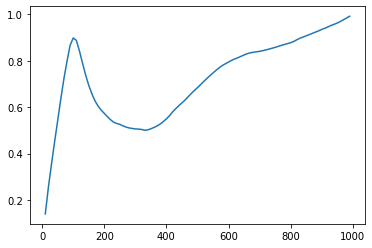

In [58]:
plt.plot([x * 10 for x in range(100)], acc)

In [62]:
dict(zip(range(100), acc))

{0: nan,
 1: 0.1399,
 2: 0.25505,
 3: 0.35483333333333333,
 4: 0.4508,
 5: 0.54336,
 6: 0.6359333333333334,
 7: 0.7233285714285714,
 8: 0.7983125,
 9: 0.8672,
 10: 0.89835,
 11: 0.8879727272727274,
 12: 0.8423416666666667,
 13: 0.7892615384615385,
 14: 0.7379857142857142,
 15: 0.69404,
 16: 0.657675,
 17: 0.6272588235294118,
 18: 0.6046888888888888,
 19: 0.5873368421052632,
 20: 0.573125,
 21: 0.5590333333333334,
 22: 0.5460363636363637,
 23: 0.5352260869565217,
 24: 0.5297416666666667,
 25: 0.52586,
 26: 0.5194923076923077,
 27: 0.5142592592592592,
 28: 0.5104535714285714,
 29: 0.5082586206896552,
 30: 0.5061933333333334,
 31: 0.5055161290322581,
 32: 0.50398125,
 33: 0.5003787878787879,
 34: 0.5021235294117647,
 35: 0.5068942857142857,
 36: 0.512575,
 37: 0.519027027027027,
 38: 0.5273,
 39: 0.5379051282051281,
 40: 0.5496575,
 41: 0.5631756097560975,
 42: 0.5798571428571428,
 43: 0.5933790697674418,
 44: 0.6065022727272728,
 45: 0.61844,
 46: 0.6307521739130435,
 47: 0.6448297872340

In [60]:
test(1)

0.016